In [1]:
import mne
import numpy as np
import os
import re
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
raw_files = set(filter(re.compile(".*.mff").match, os.listdir("./VRCP")))
fil_files = set(filter(re.compile(".*fil.mff").match, os.listdir("./VRCP")))
seg_files = set(filter(re.compile(".*seg.mff").match, os.listdir("./VRCP")))
mat_files = set(filter(re.compile(".*.mat").match, os.listdir("./VRCP")))
raw_files = raw_files - fil_files - seg_files - mat_files

In [3]:
print(fil_files)

{'VRCP-CYM-Atharva-April12_20190412_044115_fil.mff', 'VRCP-CYM-HarshaW-27-3-19_20190327_120035_fil.mff', 'VRCP-RGB-Atharva-April12_20190412_042629_fil.mff', 'VRCP-RGB-HarshaW-27-3-19_20190327_114603_fil.mff'}


In [4]:
data_ = []
psd_data_ = []
freqs_ = []
labels_ = []

time_of_event = 5 # colour was shown for 5 seconds
stride_split = 0.1 # stride of 0.2 seconds while splitting events
time_of_split = 1 # size of one window is 1 second i.e. 1000ms
num_splits = (time_of_event - time_of_split)/stride_split + 1
h_freq = 30

channels = ['E9', 'E10', 'E20']

In [5]:
print(num_splits, time_of_split)

41.0 1


In [6]:
x = 0
num_ev_fil = np.zeros(4, dtype = np.int32)

In [7]:
for ff in fil_files:
    fil_egi = mne.io.read_raw_egi("VRCP/" + ff, verbose = False)
    sfreq = fil_egi.info['sfreq']
    ev = mne.find_events(fil_egi, verbose = False)
    ev = ev[:-1] # dont use the last event as it may not be sampled for 5 seconds, epoch creation will give error
    
    tmin = 0
    tmax = time_of_split - 1/sfreq
    s = 0
    for i in range((int)(num_splits)):
        shifted_ev = mne.event.shift_time_events(ev, [1, 2, 3], i*stride_split, sfreq)
        ep = mne.Epochs(fil_egi, shifted_ev, tmin = tmin, tmax = tmax, picks = channels, baseline = (None, None), verbose = False)
        ep_fil = ep.load_data().filter(l_freq = 0, h_freq = 30)
        psd, freq = mne.time_frequency.psd_multitaper(ep_fil, fmax = 30, verbose = False)
        
        psd_data_.append(psd)
        freqs_.append(np.expand_dims(freq, axis = 1))
        labels_.append(shifted_ev[ep.selection, 2])
        s = s + len(ep.selection)
    num_ev_fil[x] = s
    x = x + 1;

In [8]:
print(num_splits)
print(num_ev_fil.sum())
print(num_ev_fil)
print(len(psd_data_), len(labels_))

41.0
10373
[2337 2419 3198 2419]
164 164


In [9]:
# # add features - sums of delta(0-4), theta(4-7), alpha(8-15), beta(16-31)

# d_max = 4
# t_max = 8
# a_max = 14
# b_max = 30

# d_r = np.searchsorted(freqs, d_max, side = 'left') 
# t_r = np.searchsorted(freqs, t_max, side = 'left') 
# a_r = np.searchsorted(freqs, a_max, side = 'left') 
# b_r = np.searchsorted(freqs, b_max, side = 'left') 

# print(psd_data.shape)

# d_sums = np.expand_dims(psd_data[:, :, :d_r].sum(2), axis = 2)
# t_sums = np.expand_dims(psd_data[:, :, d_r:t_r].sum(2), axis = 2)
# a_sums = np.expand_dims(psd_data[:, :, t_r:a_r].sum(2), axis = 2)
# b_sums = np.expand_dims(psd_data[:, :, a_r:b_r].sum(2), axis = 2)
# print(d_sums.shape, t_sums.shape, a_sums.shape, b_sums.shape)
# band_sums = np.concatenate([d_sums, t_sums, a_sums, b_sums], axis = 2)
# print(band_sums.shape)

# psd_band_data = np.concatenate([psd_data, band_sums], axis = 2)
# print(psd_band_data.shape)

In [10]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, LeakyReLU, BatchNormalization, Dropout
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/Users/advaitrane/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/advaitrane/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/advaitrane/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/advaitrane/anaconda3/lib/python3.6

In [11]:
def get_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(8, activation = 'relu'))
    model.add(Dense(3, activation = 'softmax'))
    
    return model

In [12]:
def get_data(file_no):
    start_index = (int)(num_splits * file_no)
    end_index = (int)(start_index + num_splits)
    
    labels = np.concatenate(labels_[start_index:end_index])
    psd_data = np.concatenate(psd_data_[start_index:end_index])
    freqs = freq

    labels_cat = to_categorical(labels)
    labels_cat = labels_cat[:, 1:]

    psd_train, psd_test, labels_train, labels_test = train_test_split(psd_data, 
                                                                labels_cat, test_size = 0.2, stratify = labels_cat)

    psd_train_amp = psd_train*1e9
    psd_test_amp = psd_test*1e9
    
    return psd_train_amp, psd_test_amp, labels_train, labels_test, freqs


In [47]:
def plot_channel_colours(psd_cym, psd_rgb, labels_cym, labels_rgb, freqs_cym, freqs_rgb, channel):
    c1 = {0 : 'cyan', 1 : 'yellow', 2 : 'magenta'}
    c2 = {0 : 'red', 1 : 'green', 2 : 'blue'}

    for col in range(3):
        pl.subplot(2, 3, col+1)#, figsize = (15, 15))
        for i, psd in enumerate(psd_cym):
            if(labels_cym[i, col] == 1):
                pl.plot(freqs_cym[5:], psd[channel, 5:], color = c1[col])

    for col in range(3):
        pl.subplot(2, 3, 3+col+1)#, figsize = (15, 15))
        for i, psd in enumerate(psd_rgb):
            if(labels_rgb[i, col] == 1):
                pl.plot(freqs_rgb[5:], psd[channel, 5:], color = c2[col])

    pl.show()

In [14]:
# model_a_cym = Sequential()
# model_a_cym.add(Flatten())
# # model.add(Dense(128, activation = 'relu'))
# model_a_cym.add(Dense(64, activation = 'relu'))
# model_a_cym.add(BatchNormalization())
# model_a_cym.add(Dense(32, activation = 'relu'))
# # model_a_cym.add(BatchNormalization())
# model_a_cym.add(Dense(16, activation = 'relu'))
# # model.add(BatchNormalization())
# model_a_cym.add(Dense(8, activation = 'relu'))
# # model.add(BatchNormalization())
# # model.add(LeakyReLU())
# model_a_cym.add(Dense(3, activation = 'softmax'))

psd_acym_train, psd_acym_test, labels_acym_train, labels_acym_test, freqs_acym = get_data(0) 
model_acym = get_model()

In [15]:
model_acym.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model_acym.fit(psd_acym_train, labels_acym_train, batch_size = 16, epochs = 120, verbose = 2, validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 1495 samples, validate on 374 samples
Epoch 1/120
 - 1s - loss: 1.0948 - acc: 0.3679 - val_loss: 1.0758 - val_acc: 0.4385
Epoch 2/120
 - 0s - loss: 1.0679 - acc: 0.4194 - val_loss: 1.0760 - val_acc: 0.4492
Epoch 3/120
 - 0s - loss: 1.0513 - acc: 0.4368 - val_loss: 1.0680 - val_acc: 0.4439
Epoch 4/120
 - 0s - loss: 1.0349 - acc: 0.4569 - val_loss: 1.0546 - val_acc: 0.4813
Epoch 5/120
 - 0s - loss: 1.0218 - acc: 0.4716 - val_loss: 1.0351 - val_acc: 0.4920
Epoch 6/120
 - 0s - loss: 1.0158 - acc: 0.4669 - val_loss: 1.0434 - val_acc: 0.4733
Epoch 7/120
 - 0s - loss: 1.0263 - acc: 0.4609 - val_loss: 1.0285 - val_acc: 0.4465
Epoch 8/120
 - 0s - loss: 1.0201 - acc: 0.4749 - val_loss: 1.0077 - val_acc: 0.5000
Epoch 9/120
 - 0s - loss: 1.0013 - acc: 0.4856 - val_loss: 1.0082 - val_acc: 0.4893
Epoch 10/120
 - 0s - loss: 1.0077 - acc: 0.4836 - val_loss: 1.0135 - val_acc: 0.4840
Epoch 11/120
 - 0s - loss: 1.0062 - acc: 0.4729 - val_loss: 1.01

Epoch 94/120
 - 0s - loss: 0.7214 - acc: 0.6749 - val_loss: 0.8563 - val_acc: 0.5802
Epoch 95/120
 - 0s - loss: 0.7155 - acc: 0.6742 - val_loss: 0.8032 - val_acc: 0.6096
Epoch 96/120
 - 0s - loss: 0.7228 - acc: 0.6635 - val_loss: 0.8235 - val_acc: 0.6417
Epoch 97/120
 - 0s - loss: 0.7244 - acc: 0.6783 - val_loss: 0.8252 - val_acc: 0.6310
Epoch 98/120
 - 0s - loss: 0.7004 - acc: 0.6970 - val_loss: 0.8637 - val_acc: 0.5989
Epoch 99/120
 - 0s - loss: 0.7100 - acc: 0.6863 - val_loss: 0.8270 - val_acc: 0.6123
Epoch 100/120
 - 0s - loss: 0.7130 - acc: 0.6769 - val_loss: 0.8299 - val_acc: 0.6230
Epoch 101/120
 - 0s - loss: 0.7087 - acc: 0.6910 - val_loss: 0.8983 - val_acc: 0.5936
Epoch 102/120
 - 0s - loss: 0.7139 - acc: 0.6816 - val_loss: 0.9045 - val_acc: 0.5802
Epoch 103/120
 - 0s - loss: 0.7015 - acc: 0.6803 - val_loss: 0.8117 - val_acc: 0.6310
Epoch 104/120
 - 0s - loss: 0.6954 - acc: 0.6930 - val_loss: 0.8150 - val_acc: 0.6497
Epoch 105/120
 - 0s - loss: 0.6933 - acc: 0.6983 - val_loss:

In [17]:
model_acym.evaluate(psd_acym_test, labels_acym_test)

468/468 [==============================] - 0s 96us/step


[0.7987788426570404, 0.6517094006905189]

In [19]:
psd_argb_train, psd_argb_test, labels_argb_train, labels_argb_test, freqs_argb = get_data(2)
model_argb = get_model()

In [20]:
model_argb.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [21]:
model_argb.fit(psd_argb_train, labels_argb_train, batch_size = 16, epochs = 120, verbose = 2, validation_split = 0.2)

Train on 2046 samples, validate on 512 samples
Epoch 1/120
 - 1s - loss: 1.1041 - acc: 0.3441 - val_loss: 1.0908 - val_acc: 0.3848
Epoch 2/120
 - 0s - loss: 1.0696 - acc: 0.3998 - val_loss: 1.2217 - val_acc: 0.3984
Epoch 3/120
 - 0s - loss: 1.0720 - acc: 0.4066 - val_loss: 1.0744 - val_acc: 0.3926
Epoch 4/120
 - 0s - loss: 1.0491 - acc: 0.4467 - val_loss: 1.0609 - val_acc: 0.4004
Epoch 5/120
 - 0s - loss: 1.0459 - acc: 0.4506 - val_loss: 1.0488 - val_acc: 0.4141
Epoch 6/120
 - 0s - loss: 1.0293 - acc: 0.4629 - val_loss: 1.0484 - val_acc: 0.4023
Epoch 7/120
 - 0s - loss: 1.0225 - acc: 0.4536 - val_loss: 1.0450 - val_acc: 0.4004
Epoch 8/120
 - 0s - loss: 1.0125 - acc: 0.4761 - val_loss: 1.0311 - val_acc: 0.4160
Epoch 9/120
 - 0s - loss: 1.0077 - acc: 0.4785 - val_loss: 1.0210 - val_acc: 0.4551
Epoch 10/120
 - 0s - loss: 1.0013 - acc: 0.4941 - val_loss: 1.0124 - val_acc: 0.4609
Epoch 11/120
 - 0s - loss: 0.9909 - acc: 0.4873 - val_loss: 1.0104 - val_acc: 0.4648
Epoch 12/120
 - 0s - loss: 

Epoch 97/120
 - 0s - loss: 0.7381 - acc: 0.6652 - val_loss: 0.9014 - val_acc: 0.5527
Epoch 98/120
 - 0s - loss: 0.7384 - acc: 0.6652 - val_loss: 0.8959 - val_acc: 0.5566
Epoch 99/120
 - 0s - loss: 0.7212 - acc: 0.6706 - val_loss: 0.8849 - val_acc: 0.5820
Epoch 100/120
 - 0s - loss: 0.7159 - acc: 0.6701 - val_loss: 0.8770 - val_acc: 0.6074
Epoch 101/120
 - 0s - loss: 0.7166 - acc: 0.6676 - val_loss: 0.8786 - val_acc: 0.5625
Epoch 102/120
 - 0s - loss: 0.7120 - acc: 0.6745 - val_loss: 0.8552 - val_acc: 0.5898
Epoch 103/120
 - 0s - loss: 0.7037 - acc: 0.6779 - val_loss: 0.8589 - val_acc: 0.5664
Epoch 104/120
 - 0s - loss: 0.7012 - acc: 0.6862 - val_loss: 0.8687 - val_acc: 0.5645
Epoch 105/120
 - 0s - loss: 0.7045 - acc: 0.6965 - val_loss: 0.8836 - val_acc: 0.5938
Epoch 106/120
 - 0s - loss: 0.7181 - acc: 0.6730 - val_loss: 0.8354 - val_acc: 0.5957
Epoch 107/120
 - 0s - loss: 0.7346 - acc: 0.6623 - val_loss: 0.8380 - val_acc: 0.5938
Epoch 108/120
 - 0s - loss: 0.6697 - acc: 0.6979 - val_lo

In [22]:
model_argb.evaluate(psd_argb_test, labels_argb_test)

640/640 [==============================] - 0s 68us/step


[0.8730333864688873, 0.6]

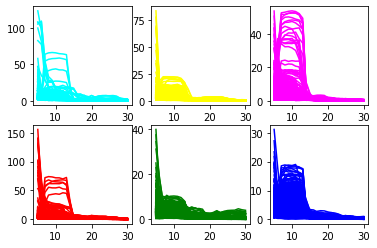

In [51]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 0)

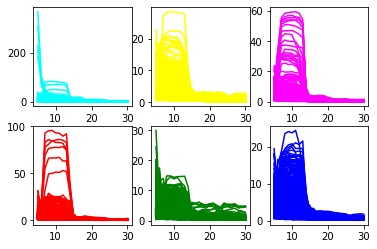

In [49]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 1)

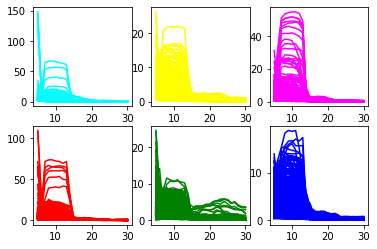

In [50]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 2)

In [29]:
psd_hcym_train, psd_hcym_test, labels_hcym_train, labels_hcym_test, freqs_hcym = get_data(1)
model_hcym = get_model()

In [30]:
model_hcym.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [31]:
model_hcym.fit(psd_hcym_train, labels_hcym_train, batch_size = 16, epochs = 120, verbose = 2, validation_split = 0.2)

Train on 1548 samples, validate on 387 samples
Epoch 1/120
 - 1s - loss: 1.0609 - acc: 0.4128 - val_loss: 1.0251 - val_acc: 0.4574
Epoch 2/120
 - 0s - loss: 0.9967 - acc: 0.4671 - val_loss: 0.9697 - val_acc: 0.5556
Epoch 3/120
 - 0s - loss: 0.9565 - acc: 0.5155 - val_loss: 0.9541 - val_acc: 0.5168
Epoch 4/120
 - 0s - loss: 0.9375 - acc: 0.5401 - val_loss: 0.9432 - val_acc: 0.5065
Epoch 5/120
 - 0s - loss: 0.9179 - acc: 0.5433 - val_loss: 0.9187 - val_acc: 0.5401
Epoch 6/120
 - 0s - loss: 0.9049 - acc: 0.5543 - val_loss: 0.9429 - val_acc: 0.5762
Epoch 7/120
 - 0s - loss: 0.9065 - acc: 0.5575 - val_loss: 0.9019 - val_acc: 0.5891
Epoch 8/120
 - 0s - loss: 0.8851 - acc: 0.5711 - val_loss: 0.9033 - val_acc: 0.5297
Epoch 9/120
 - 0s - loss: 0.8849 - acc: 0.5659 - val_loss: 0.8655 - val_acc: 0.6176
Epoch 10/120
 - 0s - loss: 0.8469 - acc: 0.5917 - val_loss: 0.8859 - val_acc: 0.5917
Epoch 11/120
 - 0s - loss: 0.8532 - acc: 0.5898 - val_loss: 0.8669 - val_acc: 0.5943
Epoch 12/120
 - 0s - loss: 

Epoch 97/120
 - 0s - loss: 0.5470 - acc: 0.7668 - val_loss: 0.6821 - val_acc: 0.7183
Epoch 98/120
 - 0s - loss: 0.5319 - acc: 0.7661 - val_loss: 0.6882 - val_acc: 0.7003
Epoch 99/120
 - 0s - loss: 0.5349 - acc: 0.7797 - val_loss: 0.7341 - val_acc: 0.7468
Epoch 100/120
 - 0s - loss: 0.5512 - acc: 0.7590 - val_loss: 0.6367 - val_acc: 0.7390
Epoch 101/120
 - 0s - loss: 0.5350 - acc: 0.7584 - val_loss: 0.8705 - val_acc: 0.6357
Epoch 102/120
 - 0s - loss: 0.5544 - acc: 0.7584 - val_loss: 0.6608 - val_acc: 0.7416
Epoch 103/120
 - 0s - loss: 0.4988 - acc: 0.7875 - val_loss: 0.7847 - val_acc: 0.6744
Epoch 104/120
 - 0s - loss: 0.5534 - acc: 0.7539 - val_loss: 0.7478 - val_acc: 0.6822
Epoch 105/120
 - 0s - loss: 0.5687 - acc: 0.7494 - val_loss: 0.7158 - val_acc: 0.6873
Epoch 106/120
 - 0s - loss: 0.5870 - acc: 0.7410 - val_loss: 0.6801 - val_acc: 0.7158
Epoch 107/120
 - 0s - loss: 0.5751 - acc: 0.7610 - val_loss: 0.6159 - val_acc: 0.7623
Epoch 108/120
 - 0s - loss: 0.5494 - acc: 0.7745 - val_lo

In [32]:
model_hcym.evaluate(psd_hcym_test, labels_hcym_test)

484/484 [==============================] - 0s 83us/step


[0.6545365595620526, 0.6880165289256198]

In [34]:
psd_hrgb_train, psd_hrgb_test, labels_hrgb_train, labels_hrgb_test, freqs_hrgb = get_data(3)
model_hrgb = get_model()

In [35]:
model_hrgb.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [36]:
model_hrgb.fit(psd_hrgb_train, labels_hrgb_train, batch_size = 16, epochs = 120, verbose = 2, validation_split = 0.2)

Train on 1548 samples, validate on 387 samples
Epoch 1/120
 - 1s - loss: 1.1059 - acc: 0.3857 - val_loss: 1.0947 - val_acc: 0.4315
Epoch 2/120
 - 0s - loss: 1.0530 - acc: 0.4283 - val_loss: 1.1082 - val_acc: 0.4599
Epoch 3/120
 - 0s - loss: 1.0388 - acc: 0.4503 - val_loss: 1.0879 - val_acc: 0.4677
Epoch 4/120
 - 0s - loss: 1.0220 - acc: 0.4839 - val_loss: 1.0899 - val_acc: 0.4264
Epoch 5/120
 - 0s - loss: 1.0030 - acc: 0.4806 - val_loss: 1.0531 - val_acc: 0.4548
Epoch 6/120
 - 0s - loss: 0.9942 - acc: 0.5000 - val_loss: 1.0840 - val_acc: 0.4315
Epoch 7/120
 - 0s - loss: 0.9890 - acc: 0.4968 - val_loss: 1.0666 - val_acc: 0.4651
Epoch 8/120
 - 0s - loss: 0.9689 - acc: 0.5284 - val_loss: 1.0628 - val_acc: 0.4780
Epoch 9/120
 - 0s - loss: 0.9730 - acc: 0.5291 - val_loss: 1.0565 - val_acc: 0.4470
Epoch 10/120
 - 0s - loss: 0.9551 - acc: 0.5426 - val_loss: 1.0397 - val_acc: 0.5297
Epoch 11/120
 - 0s - loss: 0.9436 - acc: 0.5530 - val_loss: 0.9854 - val_acc: 0.5271
Epoch 12/120
 - 0s - loss: 

Epoch 97/120
 - 0s - loss: 0.5276 - acc: 0.7765 - val_loss: 0.7715 - val_acc: 0.6718
Epoch 98/120
 - 0s - loss: 0.5067 - acc: 0.7894 - val_loss: 0.6755 - val_acc: 0.6796
Epoch 99/120
 - 0s - loss: 0.5285 - acc: 0.7771 - val_loss: 0.7377 - val_acc: 0.6925
Epoch 100/120
 - 0s - loss: 0.5188 - acc: 0.7817 - val_loss: 0.7726 - val_acc: 0.6486
Epoch 101/120
 - 0s - loss: 0.5636 - acc: 0.7649 - val_loss: 0.7064 - val_acc: 0.6848
Epoch 102/120
 - 0s - loss: 0.5049 - acc: 0.7926 - val_loss: 0.6838 - val_acc: 0.7183
Epoch 103/120
 - 0s - loss: 0.5034 - acc: 0.7926 - val_loss: 0.7222 - val_acc: 0.6873
Epoch 104/120
 - 0s - loss: 0.5334 - acc: 0.7584 - val_loss: 0.7174 - val_acc: 0.6770
Epoch 105/120
 - 0s - loss: 0.4960 - acc: 0.8049 - val_loss: 0.6630 - val_acc: 0.7080
Epoch 106/120
 - 0s - loss: 0.5182 - acc: 0.7791 - val_loss: 0.6112 - val_acc: 0.7183
Epoch 107/120
 - 0s - loss: 0.4921 - acc: 0.7959 - val_loss: 0.7824 - val_acc: 0.6977
Epoch 108/120
 - 0s - loss: 0.5095 - acc: 0.7907 - val_lo

In [38]:
model_hrgb.evaluate(psd_hrgb_test, labels_hrgb_test)

484/484 [==============================] - 0s 835us/step


[0.8452535366470163, 0.6528925619834711]

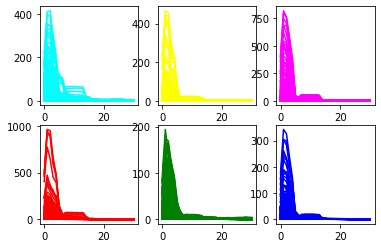

In [39]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 0)

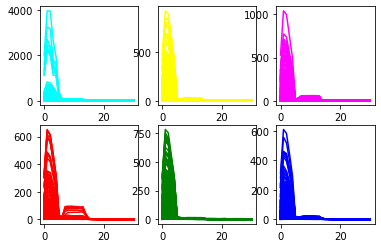

In [40]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 1)

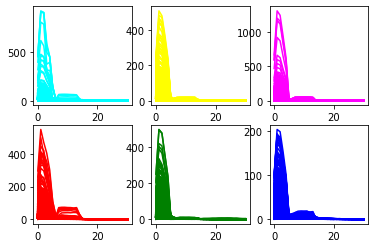

In [41]:
plot_channel_colours(psd_acym_train, psd_argb_train, labels_acym_train, labels_argb_train, freqs_acym, freqs_argb, 2)